In [87]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from xgboost import XGBClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier,
    GradientBoostingClassifier
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# 5. Model Training

In [88]:
# Load individual train and test dataset arrays
train_array = np.load('train_array.npy')
test_array = np.load('test_array.npy')

In [89]:
X_train, y_train, X_test, y_test = (
    train_array[:, :-1],
    train_array[:, -1],
    test_array[:, :-1],
    test_array[:, -1]
)

In [90]:
print(X_train[:5])
print(y_train[:5])

[[ 1.20068596e+01  1.98147472e+00 -1.13072593e-01  3.07920000e+04
   3.54770000e+04  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 6.62968537e-01  8.64077258e-01  7.32170486e+00  2.23540000e+04
   2.63190000e+04  1.20000000e+01  1.20000000e+01  0.00000000e+00]
 [ 4.66769328e+00  1.88922173e+00  6.10589071e-02  2.81690000e+04
   3.10720000e+04  9.00000000e+00  9.00000000e+00  3.00000000e+00]
 [ 2.31617261e-01 -3.40634255e-02  8.68951820e+00  1.55240000e+04
   1.19430000e+04  6.00000000e+00  6.00000000e+00  3.00000000e+00]
 [-3.44731040e-01  2.72490432e-02  5.01890565e-01  1.96080000e+04
   1.64140000e+04  3.00000000e+00  3.00000000e+00  4.00000000e+00]]
[0. 0. 0. 0. 0.]


#### Oversamplig the data and cross validating by using different models


In [91]:
"""  Imbalance dataset - upsampling """
def upsampling_data(X, y):
    sm = SMOTE(sampling_strategy='auto', random_state=42)
    X_sm, y_sm = sm.fit_resample(X, y)   
    print(f"\n====== Upsampled the minority class data ======") 
    print("Before SMOTE: ", Counter(y))
    print("After SMOTE: ", Counter(y_sm))
    return X_sm, y_sm


""" Evaluating Models """
def model_evaluation(model, X, y, num_procs):
    # parallel cross-validate models
    print("\n===================== Beginning cross validation ========================== ")
    # Define cross-validation method
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    # Define metrics
    metrics = {
        'Precision': make_scorer(precision_score, average='weighted'),
        'Recall': make_scorer(recall_score, average='weighted'),
        'F1 score': make_scorer(f1_score, average='weighted')
    }
    # Perform cross-validation and evaluate using different metrics
    metrics_results = {}
    for name, metric in metrics.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring=metric).mean()
        metrics_results[name] = scores
    return metrics_results


""" Calculate Metrics """
def model_metrics(y_test, y_pred):    
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred) 
    return precision, recall, f1, cm

##### Models evaluation 

In [92]:
"""
    Evaluating Models
    - Random_Forest
    - AdaBoost
    - XGBoost
"""

# Initialize the classifiers
models = {
    "Random_Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    # "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier()
}


# Define the hyperparameters and their possible values
params = {
    "Random_Forest": {
        'n_estimators': [50, 100, 200],
        # 'criterion': ['gini', 'entropy'],
        # 'max_depth': [None, 10, 20, 30],
        # 'min_samples_split': [2, 5, 10],
        # 'min_samples_leaf': [1, 2, 4],
        # 'max_features': ['sqrt', 'log2', None]
    },
    "AdaBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5, 1.0],
        # 'algorithm': ['SAMME', 'SAMME.R']
    },
    # "Gradient Boosting": {
    #     # 'n_estimators': [50, 100, 200],
    #     # 'learning_rate': [0.01, 0.1, 0.05, 0.001],
    #     # 'subsample': [0.6, 0.7, 0.8, 0.9],
    #     # 'max_depth': [3, 5, 7, 9],
    #     # 'min_samples_split': [2, 5, 10],
    #     # 'min_samples_leaf': [1, 2, 4]
    # },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.05, 0.001],
        # 'max_depth': [3, 5, 7, 9],
        # 'min_child_weight': [1, 3, 5],
        # 'gamma': [0, 0.1, 0.2],
        # 'subsample': [0.6, 0.7, 0.8, 0.9],
        # 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
    }
}


# Initialize StratifiedKFold with 5 folds
# Stratified K-Fold ensures that each fold has the same proportion of classes as the entire dataset. 
skf = StratifiedKFold(n_splits=5)

# Upsampling train data
X_train_sm, y_train_sm = upsampling_data(X_train, y_train)

train_report = {}
test_report = {}
for i in range(len(models)):
    model = list(models.values())[i]
    param = params[list(models.keys())[i]]
    print(f"\n================ {model} ==================================")
    # Initalize GridSearchCV with 5-fold stratified cross validation
    # n_jobs is set to -1, to use all available CPU cores on the machine
    # verbose=2 to track the progress grid search or model training.
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=param, 
                               cv=skf,
                               n_jobs=-1,
                               verbose=2)

    # Fit the grid search model
    grid_search.fit(X_train_sm, y_train_sm)
    print(f"Best parameters: {grid_search.best_params_} for {model}")

    # Set the model with best hyperparameters
    model.set_params(**grid_search.best_params_)
    # Fit the model
    model.fit(X_train_sm, y_train_sm)

    # Predict on Train data
    y_train_pred = model.predict(X_train_sm)
    # Predict on Test data
    y_test_pred = model.predict(X_test)

    # Get evaluation metrics for train and test data using best hyperparametrs
    print(f"Obtaining evaluation metrics for {model} by using best hyperparameters")
    precision_train, recall_train, f1_train, cm_train = model_metrics(y_train_sm, y_train_pred)
    train_model_score = []
    train_model_score.append({
        "Precision" : precision_train,
        "Recall" : recall_train,
        "F1 score": f1_train,
        "Confusion Matrix": cm_train
    })
    train_report[list(models.keys())[i]] = train_model_score

    precision_test, recall_test, f1_test, cm_test = model_metrics(y_test, y_test_pred)
    test_model_score = []
    test_model_score.append({
        "Precision" : precision_test,
        "Recall" : recall_test,
        "F1 score": f1_test,
        "Confusion Matrix": cm_test
    })
    test_report[list(models.keys())[i]] = test_model_score

    print("=============================================================\n\n")

print(f"Model performance on Training Data: \n{train_report}")
print(f"-----------------------------------------------------")
print(f"Model performance on Test Data: \n{test_report}")



====== Upsampled the minority class data ======
Before SMOTE:  Counter({0.0: 39959, 1.0: 41})
After SMOTE:  Counter({0.0: 39959, 1.0: 39959})

================ RandomForestClassifier() ==================================
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'n_estimators': 50} for RandomForestClassifier()
Obtaining evaluation metrics for RandomForestClassifier(n_estimators=50) by using best hyperparameters



================ AdaBoostClassifier() ==================================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'learning_rate': 1.0, 'n_estimators': 200} for AdaBoostClassifier()
Obtaining evaluation metrics for AdaBoostClassifier(n_estimators=200) by using best hyperparameters



================ XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
      

#### Models evaluation results on training data and test data

In [93]:
train_report_df = pd.DataFrame({
    'Model': list(train_report.keys()),
    'Precision': [metrics[0]['Precision'] for metrics in train_report.values()],
    'Recall': [metrics[0]['Recall'] for metrics in train_report.values()],
    'F1 Score': [metrics[0]['F1 score'] for metrics in train_report.values()],
    'Confusion Matrix': [metrics[0]['Confusion Matrix'] for metrics in train_report.values()]
})
print(f"Model performance on Train data: \n{train_report_df}\n")

test_report_df = pd.DataFrame({
    'Model': list(test_report.keys()),
    'Precision': [metrics[0]['Precision'] for metrics in test_report.values()],
    'Recall': [metrics[0]['Recall'] for metrics in test_report.values()],
    'F1 Score': [metrics[0]['F1 score'] for metrics in test_report.values()],
    'Confusion Matrix': [metrics[0]['Confusion Matrix'] for metrics in test_report.values()]
})
print(f"Model performance on Test data: \n{test_report_df}")


Model performance on Train data: 
           Model  Precision    Recall  F1 Score               Confusion Matrix
0  Random_Forest   0.999987  0.999987  0.999987       [[39959, 0], [1, 39958]]
1       AdaBoost   0.980611  0.980205  0.980201  [[38587, 1372], [210, 39749]]
2        XGBoost   0.999375  0.999374  0.999374      [[39914, 45], [5, 39954]]

Model performance on Test data: 
           Model  Precision  Recall  F1 Score         Confusion Matrix
0  Random_Forest   0.997561  0.9968  0.997176    [[9967, 20], [12, 1]]
1       AdaBoost   0.998483  0.8742  0.931609  [[8731, 1256], [2, 11]]
2        XGBoost   0.997624  0.9908  0.994138    [[9906, 81], [11, 2]]


In [94]:
test_report

{'Random_Forest': [{'Precision': 0.9975609427416623,
   'Recall': 0.9968,
   'F1 score': 0.9971758294983826,
   'Confusion Matrix': array([[9967,   20],
          [  12,    1]], dtype=int64)}],
 'AdaBoost': [{'Precision': 0.998482567850168,
   'Recall': 0.8742,
   'F1 score': 0.9316088501602564,
   'Confusion Matrix': array([[8731, 1256],
          [   2,   11]], dtype=int64)}],
 'XGBoost': [{'Precision': 0.9976235608563122,
   'Recall': 0.9908,
   'F1 score': 0.9941379890139337,
   'Confusion Matrix': array([[9906,   81],
          [  11,    2]], dtype=int64)}]}

#### Models and its corresponding Recall score from test training report

In [95]:
models_recall_score = {model: recall_result[0]["Recall"] for model, recall_result in test_report.items()}
print(f"The models and their corresponding Recall score: \n{models_recall_score}")

The models and their corresponding Recall score: 
{'Random_Forest': 0.9968, 'AdaBoost': 0.8742, 'XGBoost': 0.9908}


#### Finding the best model and its score

In [96]:
best_model_name, best_score = max(models_recall_score.items(), key=lambda item: item[1])
print(f"Best Model name is {best_model_name} with Recall score: {best_score}")

# Get best model
best_model = models[best_model_name]
print(f"Best Model: {best_model}")

Best Model name is Random_Forest with Recall score: 0.9968
Best Model: RandomForestClassifier(n_estimators=50)


In [97]:
# Initialize the the best model 
best_model = RandomForestClassifier(n_estimators=200)
# Train the model on the training data
rfc_best = best_model.fit(X_train_sm, y_train_sm)

In [98]:
rfc_best.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(n_estimators=200)>

In [99]:
# Predict the labels for the test set
y_pred = rfc_best.predict(X_test)
print(y_pred)

[0. 0. 0. ... 0. 1. 0.]


In [100]:
precision_train, recall_train, f1_train, cm_train = model_metrics(y_test, y_pred)
result_dict = {"Final Model": best_model_name,
               "Precision" : precision_test,
               "Recall" : recall_test,
               "F1 score": f1_test,
               "Confusion Matrix": cm_test}
final_results = pd.DataFrame([result_dict])
final_results

,Final Model,Precision,Recall,F1 score,Confusion Matrix
0,Random_Forest,0.997624,0.9908,0.994138,"[[9906, 81], [11, 2]]"


Probabilities prediction of 'Is Laundering':
 [0.22  0.    0.    ... 0.03  0.755 0.005]


<Figure size 400x400 with 0 Axes>

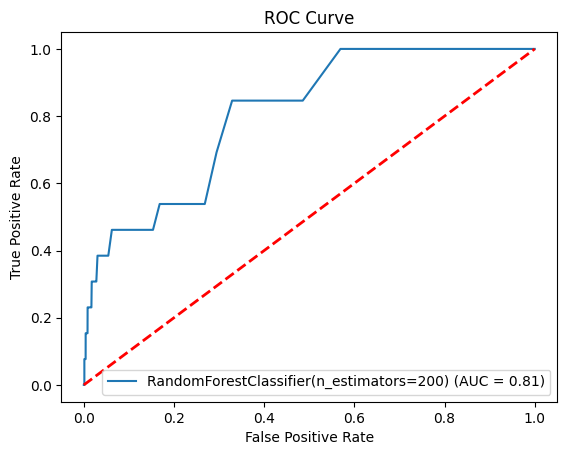

In [101]:
# Predict the probabilities for the test set
test_probabilities = rfc_best.predict_proba(X_test)[:, 1]
print(f"Probabilities prediction of 'Is Laundering':\n {test_probabilities}")

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, test_probabilities)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(4,4))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=rfc_best).plot()
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.title('ROC Curve')
plt.show()

Closet threshold to get Desired TPR of around 88.0%: 0.03
False Positive Rate (FPR): 0.329
True Positive Rate (TPR): 0.846


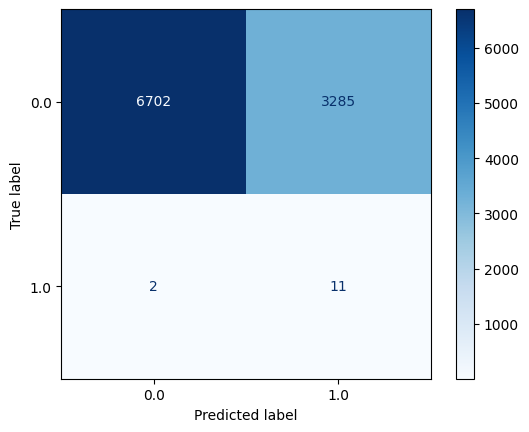

Classification report: 
               precision    recall  f1-score   support

         0.0       1.00      0.67      0.80      9987
         1.0       0.00      0.85      0.01        13

    accuracy                           0.67     10000
   macro avg       0.50      0.76      0.40     10000
weighted avg       1.00      0.67      0.80     10000



In [102]:
# Compute the True Positive Rate (tPR) and False Positive Rate (FPR) for a specific threshold value
desired_tpr = 0.88
closest_threshold = thresholds[np.argmin(np.abs(tpr - desired_tpr))]
print(f"Closet threshold to get Desired TPR of around {desired_tpr*100}%: {closest_threshold}")

y_pred = (test_probabilities >= closest_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

fpr_cm = fp / (fp + tn)
tpr_cm = tp / (tp + fn)
print(f"False Positive Rate (FPR): {fpr_cm:.3f}")
print(f"True Positive Rate (TPR): {tpr_cm:.3f}")

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.show()

print(f"Classification report: \n {classification_report(y_test, y_pred)}")

#### Best model is Random Forest with Recall (True Postive Rate) of ~99%